# Moment-Curvature Verification
This notebook is a verification report for the calculation of the Moment-Curvature with "mkappa.py" of the [bmcs_cross_section](https://github.com/bmcs-group/bmcs_cross_section) package.


In [1]:
%matplotlib widget
from bmcs_cross_section.api import ReinfLayer, BarLayer, EC2, MKappa, TShape
import bmcs_utils.api as bu
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import numpy as np

In [2]:
bu.set_latex_mpl_format()
plot_colors = bu.plot_colors

def plot_mk_ver(mc, ver_data, test_name, title=None, ax=None, color_i=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    mc.plot_mk(ax, dashed=True, color=plot_colors[color_i])
    k = ver_data[0]
    m = ver_data[1]
    ax.plot(k, m, c=plot_colors[color_i], label= 'Exp. (' + test_name + ')')
    if title is not None:
        ax.set_title(title)
    ax.legend()
    if 'fig' in locals():
        return fig, ax

def make_mc(form='rectangular', B=200, H=200, 
            material_r1='steel', E_r1=200000, high_kappa = 0.00005,
            f_cm=40, matrix = 'EC2', eps_cr = None, eps_cy=None, eps_cu=None, eps_tu=None, mu=None, E_cc=None, E_ct=None,
            f_ctm=None,
            z_r1=10,
            A_r1=100,
            f_t_r1=None,
            f_sy_r1=500,
            f_st_r1=None,
            eps_ud_r1=0.025,
            material_r2=None, 
            z_r2=None, 
            A_r2=None,
            E_r2=None,
            f_t_r2=None,
            f_sy_r2=None,
            f_st_r2=None,
            eps_ud_r2=0.025,
            n_kappa=200, n_m = 200, slider=None):
    
    mc = MKappa(low_kappa=0, 
                high_kappa=high_kappa,
                n_m=n_m,
                n_kappa=n_kappa)
    
    mc.cs_design.matrix = matrix
    if slider is not None:
        mc.kappa_slider = slider
    
    if form=='rectangular':
        mc.cross_section_shape_.B = B
        mc.cross_section_shape_.H = H
    
    if matrix == 'piecewise linear':
        mc.cs_design.matrix_.trait_set(
        eps_cy = eps_cy,
        eps_cu = eps_cu,
    )
    else:
        mc.cs_design.matrix_.f_cm=f_cm
        
    if eps_tu is not None:
        mc.cs_design.matrix_.eps_tu = eps_tu
    if eps_cr is not None:
        mc.cs_design.matrix_.eps_cr = eps_cr
    if mu is not None:
        mc.cs_design.matrix_.mu = mu
    if E_cc is not None:
        mc.cs_design.matrix_.E_cc = E_cc
    if E_ct is not None:
        mc.cs_design.matrix_.E_ct = E_ct
    
    bl1 = ReinfLayer(name='layer1', z=z_r1, A=A_r1, matmod=material_r1)
    if material_r1 == 'carbon':
        bl1.matmod_.trait_set(E=E_r1,f_t=f_t_r1)
    if material_r1 == 'steel':
        bl1.matmod_.trait_set(E_s=E_r1, f_sy=f_sy_r1, eps_ud = eps_ud_r1, f_st=1.05*f_sy_r1 if f_st_r1 is None else f_st_r1)
    mc.cross_section_layout.add_layer(bl1)
    
    if material_r2 is not None:
        bl2 = ReinfLayer(name='layer2', z=z_r2, A=A_r2, matmod=material_r2)
        if material_r2 == 'carbon':
            bl2.matmod_.trait_set(E=E_r2,f_t=f_t_r2)
        if material_r2 == 'steel':
            bl2.matmod_.trait_set(E_s=E_r2, f_sy=f_sy_r2, eps_ud = eps_ud_r2, f_st=1.05*f_sy_r2 if f_st_r2 is None else f_st_r2)
        mc.cross_section_layout.add_layer(bl2)
    
    return mc

def get_data(element1, xlsx_file, k, m, element2=False, k_faktor=False):
    if element2 == False:
        excel_file = join(element1, xlsx_file)
    else: excel_file = join(element1, element2, xlsx_file)
    data = pd.read_excel(excel_file, engine='openpyxl')
    if(k_faktor==False):
        k_faktor = 1
    k = data[k]*k_faktor
    m = data[m]
    ver_data = [k, m]
    
    return ver_data

## 1. Checking the model with its default parameters

In [3]:
mc = MKappa()
bl1 = ReinfLayer(name='steel 1', z=10, A=100, count=2 )
csl = mc.cross_section_layout
csl.add_layer(bl1)

In [ ]:
mc.interact()

## 2. Model validation with experimental results

### Rectangluar cross sections

### Gribniak et al. (2012) (FRC with Steel reinforcement), https://doi.org/10.1016/j.engstruct.2012.04.032
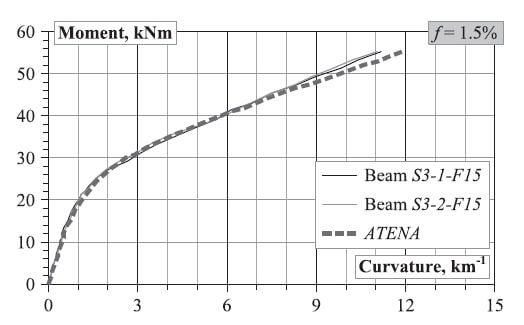

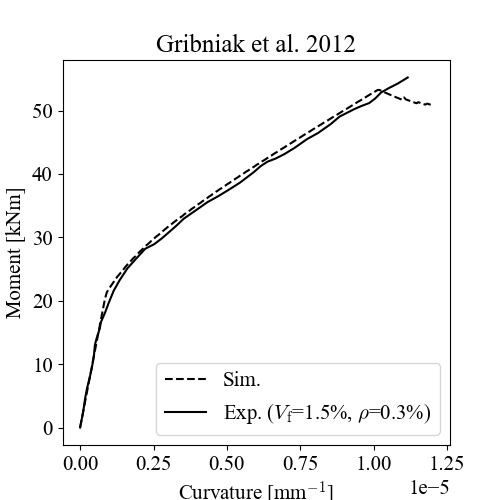

In [3]:
# Beam S3-1-F15
ver_data = get_data(element1='verification_data',
                    xlsx_file='fig_6.xlsx',
                    k='S3_1_F15_Curvature',
                    m='S3_1_F15_Moment',
                    element2='Gribniak2012')
mc = make_mc(form='rectangular', high_kappa=12e-6, B=279, H=300,
             mu=0.61, eps_cr=0.000132, eps_tu=0.0023,
             f_cm=52.2,
#              eps_cy=0.00175, eps_cu=0.0035, 
             material_r1='steel', z_r1=(300-272), A_r1=235, E_r1=202800, f_sy_r1=560,
             material_r2='steel', z_r2=(300-26), A_r2=56, E_r2=202800, f_sy_r2=560)
fig, ax = plot_mk_ver(mc, ver_data, r'$V_\mathrm{f}$=1.5%, $\rho$=0.3%', title='Gribniak et al. 2012', color_i=0)
# mc.interact()

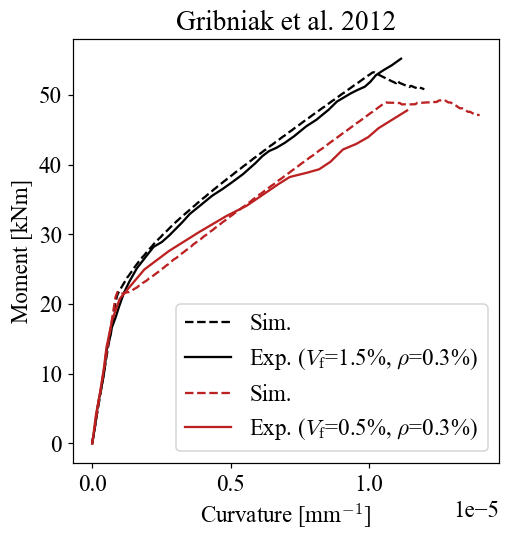

In [4]:
# Beam S3_1_F05
ver_data = get_data(element1='./verification_data/Gribniak2012/', xlsx_file='fig_6.xlsx', k='S3_1_F05_Curvature', m='S3_1_F05_Moment')
mc = make_mc(form='rectangular', high_kappa=14e-6, B=278, H=302,
             mu=0.42, eps_cr=0.000132, eps_tu=0.0025,
             f_cm=55.6,
#              eps_cy=0.00175, eps_cu=0.0035, 
             material_r1='steel', z_r1=(302-278), A_r1=235, E_r1=202800, f_sy_r1=560,
             material_r2='steel', z_r2=(302-29), A_r2=56, E_r2=202800, f_sy_r2=560)
plot_mk_ver(mc, ver_data, r'$V_\mathrm{f}$=0.5%, $\rho$=0.3%', ax=ax, color_i=1)
fig
# mc.interact()

In [ ]:
# fig.savefig('MK_Gribniak_S3-1-F15_S3-1-F05.pdf')

### Yang et al. (2010) (FRC with steel reinforcement), http://dx.doi.org/10.1016/j.engstruct.2010.07.017
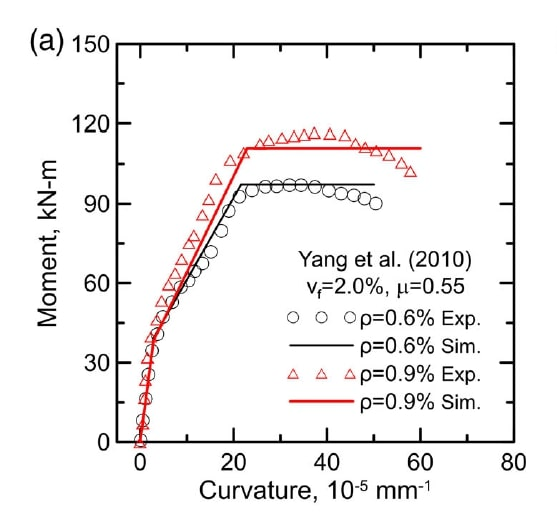

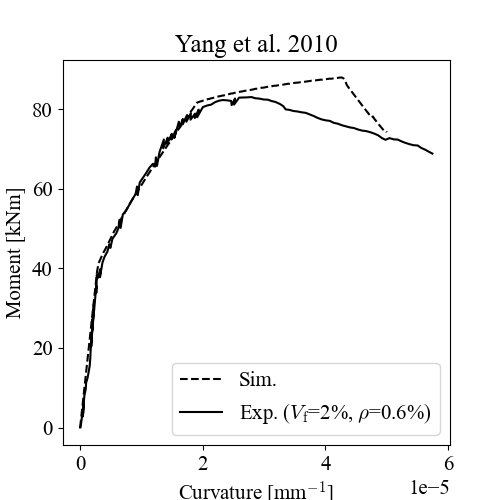

In [17]:
# R12-1,2 (rho = 0.6%)
ver_data = get_data(element1='./verification_data/yang2010', element2='fig_18', xlsx_file='yang2010.xlsx', k='beam_R12_2_Curvature', m='beam_R12_2_Moment')
mc = make_mc(
            form='rectangular', high_kappa=0.00005, B=180, H=270,
            matrix='piecewise linear',
            E_cc=46418, E_ct=46418,
            mu=0.55,
            eps_cr=0.000384,
            eps_tu = 24 * 0.000384,
            eps_cy = 190.9/46418,
            eps_cu = EC2.get_eps_cu3(190.9-8),
            material_r1='steel', z_r1=35, A_r1=253.4, E_r1=200000, f_sy_r1=600,
            )
fig, ax = plot_mk_ver(mc, ver_data, r'$V_\mathrm{f}$=2%, $\rho$=0.6%', title='Yang et al. 2010', color_i=0)
fig.show()
# mc.interact()

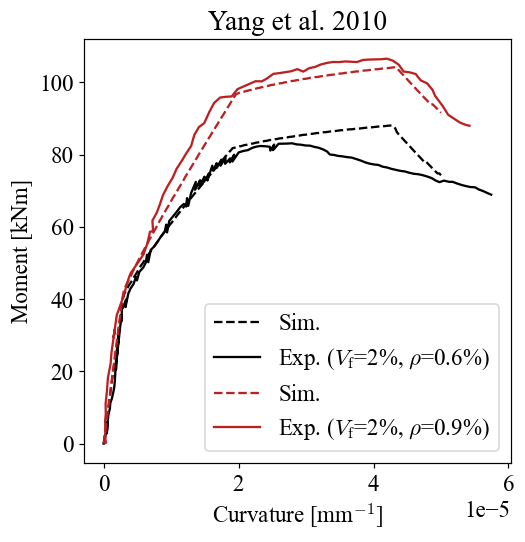

In [15]:
# R13-2 (rho = 0.9%)
ver_data = get_data(element1='./verification_data/yang2010', element2='fig_18', xlsx_file='yang2010.xlsx', k='beam_R13_2_Curvature', m='beam_R13_2_Moment')
mc = make_mc(form='rectangular', high_kappa=0.00005, B=180, H=270,
            matrix='piecewise linear',
            E_cc=46680, E_ct=46680,
            mu=0.55,
            eps_cr=0.000384,
            eps_tu = 24 * 0.000384,
            eps_cy = 192.2/46680,
            eps_cu = EC2.get_eps_cu3(192.2-8),
            material_r1='steel', z_r1=35, A_r1=380.1, E_r1=200000, f_sy_r1=600,
            )
plot_mk_ver(mc, ver_data, r'$V_\mathrm{f}$=2%, $\rho$=0.9%', ax=ax, color_i=1)
fig
# mc.interact()

In [ ]:
fig.savefig('MK_Yang_R12-1_R13-2.pdf')

### Aiello 2002 (rect. cross-section, hybrid reinf.)  - skipped!
https://www.researchgate.net/publication/248879121_Structural_Performances_of_Concrete_Beams_with_Hybrid_Fiber-Reinforced_Polymer-Steel_Reinforcements

In [ ]:
# A1 (Steel + AFRP):
ver_data = get_data(element1='./verification_data/Aiello2002', xlsx_file='fig_3.xlsx', k='A1_Curvature', m='A1_Moment')
mc = make_mc(form='rectangular', high_kappa=0.0002, B=150, H=200,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=45.7,
             eps_cr=4.03/EC2.get_E_cm(45.7-8),
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 100.48, E_r1 = 200000, z_r1=50, f_sy_r1=465,
             A_r2 = 100.48,  E_r2 = 200000, z_r2=200-25, f_sy_r2=465
            )

l1 = ReinfLayer(name='carbon', z=25, A=88.31, matmod='carbon')
l1.matmod_.trait_set(E=49000, f_t=1674)
mc.cross_section_layout.add_layer(l1)

fig, ax = plot_mk_ver(mc, ver_data, r'A1 - Hybrid reinf. [Steel + AFRP]', title='Aiello et. al. 2002', color_i=0)
# mc.interact()

In [ ]:
# A2:
ver_data = get_data(element1='./verification_data/Aiello2002', xlsx_file='fig_3.xlsx', k='A2_Curvature', m='A2_Moment')
mc = make_mc(form='rectangular', high_kappa=0.0002, B=150, H=200,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=45.7,
             eps_cr=4.03/EC2.get_E_cm(45.7-8),
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 100.48, E_r1 = 200000, z_r1=50, f_sy_r1=465,
             A_r2 = 100.48,  E_r2 = 200000, z_r2=200-25, f_sy_r2=465
            )

l1 = ReinfLayer(name='carbon', z=25, A=157, matmod='carbon')
l1.matmod_.trait_set(E=50100, f_t=1366)
mc.cross_section_layout.add_layer(l1)

plot_mk_ver(mc, ver_data, r'A2 - Hybrid reinf. [Steel + AFRP]', ax=ax, color_i=1)
fig
# mc.interact()

In [ ]:
# B2:
ver_data = get_data(element1='./verification_data/Aiello2002', xlsx_file='fig_3.xlsx', k='B2_Curvature', m='B2_Moment')
mc = make_mc(form='rectangular', high_kappa=0.0003, B=150, H=200,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=45.7,
             eps_cr=4.03/EC2.get_E_cm(45.7-8),
            material_r1='carbon',
             material_r2 = 'steel',
             A_r1 = 88.31, E_r1 = 49000, z_r1=25, f_t_r1=1674,
             A_r2 = 100.48,  E_r2 = 200000, z_r2=200-25, f_sy_r2=465
            )
plot_mk_ver(mc, ver_data, 'Aiello et. al. (2002) B2')
mc.interact()

In [ ]:
# B1:
ver_data = get_data(element1='./verification_data/Aiello2002', xlsx_file='fig_3.xlsx', k='B1_Curvature', m='B1_Moment')
mc = make_mc(form='rectangular', high_kappa=0.0003, B=150, H=200,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=45.7,
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 226.08, E_r1 = 200000, z_r1=25, f_sy_r1=465,
             A_r2 = 100.48,  E_r2 = 200000, z_r2=200-25, f_sy_r2=465
            )
plot_mk_ver(mc, ver_data, 'Almusallam (1997) Group 2')
mc.interact()

###  Almusallam1997 (Steel, GFRP) https://journals.sagepub.com/doi/pdf/10.1177/002199839703100701

In [ ]:
# Group 1 (Steel):
ver_data = get_data(element1='./verification_data/Almusallam1997', xlsx_file='fig_9_10_11.xlsx', k='Group_1_Curvature', m='Group_1_Moment')
mc = make_mc(form='rectangular', high_kappa=0.000065, B=200, H=210,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 3*np.pi*7**2, E_r1 = 200000, z_r1=50, f_sy_r1=553,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
fig, ax = plot_mk_ver(mc, ver_data, r'Group 1 - Steel', title='Almusallam 1997', color_i=0)
# mc.interact()

In [ ]:
# Group 2 (GFRP):
ver_data = get_data(element1='./verification_data/Almusallam1997', xlsx_file='fig_9_10_11.xlsx', k='Group_2_Curvature', m='Group_2_Moment')
mc = make_mc(form='rectangular', high_kappa=0.000066, B=200, H=210,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='carbon',
             material_r2 = 'steel',
             A_r1 = 4*np.pi*(19/2)**2, E_r1 = 35630, z_r1=210-158, f_t_r1=700,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
plot_mk_ver(mc, ver_data, r'Group 2 - GFRP', ax=ax, color_i=1)
fig
# mc.interact()

In [ ]:
# Group 3 (GFRP):
ver_data = get_data(element1='./verification_data/Almusallam1997', xlsx_file='fig_9_10_11.xlsx', k='Group_3_Curvature', m='Group_3_Moment')
mc = make_mc(form='rectangular', high_kappa=0.00007, B=200, H=260,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='carbon',
             material_r2 = 'steel',
             A_r1 = 4*np.pi*(12.7/2)**2, E_r1 = 43370, z_r1=260-211, f_t_r1=886,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
plot_mk_ver(mc, ver_data, r'Group 3 - GFRP', ax=ax, color_i=2)
fig
# mc.interact()

In [ ]:
# fig.savefig('MK_Almusallam1997.pdf')

### Bazan2020 (Steel reinf. strengthened with CFRP sheet )

In [9]:
# SC-01:
ver_data = get_data(element1='./verification_data/Bazan2020', xlsx_file='fig_7.xlsx', k='SC-01_Curvature', m='SC-01_Moment')
mc = make_mc(form='rectangular', high_kappa=0.000037, B=200, H=400,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=30,
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 3*np.pi*(16/2)**2, E_r1 = 200000, z_r1=400-342, f_sy_r1=500, # f_sy =420 acc. to paper
             A_r2 = 2*np.pi*(8/2)**2,  E_r2 = 200000, z_r2=342, f_sy_r2=500
             
            )
l1 = ReinfLayer(name='carbon', z=0, A=200, matmod='carbon')
l1.matmod_.trait_set(E=95800,f_t=985)
mc.cross_section_layout.add_layer(l1)

fig, ax = plot_mk_ver(mc, ver_data, 'SC-01 - [Steel + CFRP]', title='Bazan et al. 2020', color_i=0)
# mc.interact()

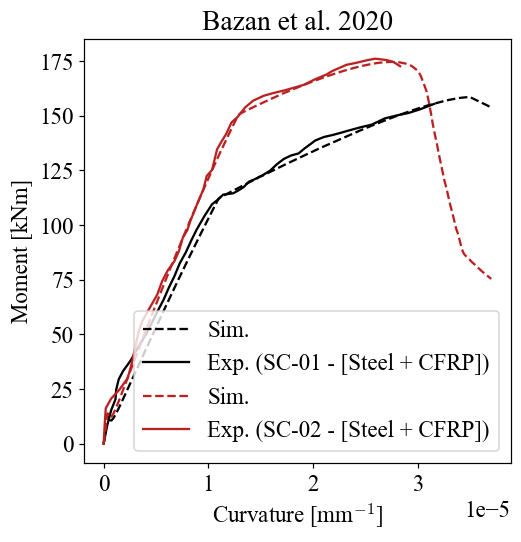

In [10]:
# SC-02:
ver_data = get_data(element1='./verification_data/Bazan2020', xlsx_file='fig_7.xlsx', k='SC-02_Curvature', m='SC-02_Moment')
mc = make_mc(form='rectangular', high_kappa=0.000037, B=200, H=400,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=30,
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 4*np.pi*(16/2)**2 + 1*np.pi*(12/2)**2, E_r1 = 200000, z_r1=400-329, f_sy_r1=500, # f_sy =420 acc. to paper
             A_r2 = 2*np.pi*(8/2)**2,  E_r2 = 200000, z_r2=329, f_sy_r2=500
            )
l1 = ReinfLayer(name='carbon', z=0, A=200, matmod='carbon')
l1.matmod_.trait_set(E=95800,f_t=985)
mc.cross_section_layout.add_layer(l1)

plot_mk_ver(mc, ver_data, 'SC-02 - [Steel + CFRP]', ax=ax, color_i=1)
fig
# mc.interact()

In [ ]:
# fig.savefig('MK_Bazan2020.pdf')

### Verification with T-sections

### Joshi 2018
http://dx.doi.org/10.15224/978-1-63248-079-8-50, Steel reinforcement

In [ ]:
# Beam: 1S5R12

mc = make_mc(high_kappa=0.00007, eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=25,
             material_r1='steel',
             A_r1 = 3*np.pi*(12/2)**2,  E_r1 = 200000, z_r1=40, f_sy_r1=500,
             A_r2 = 1*np.pi*(10/2)**2,  E_r2 = 200000, z_r2=174-40, f_sy_r2=500,
            )
mc.cross_section_shape = 'T-shape'
mc.cross_section_shape_.B_f = 770
mc.cross_section_shape_.B_w = 230
mc.cross_section_shape_.H = 174
mc.cross_section_shape_.H_w = 174-50

mc.interact()

### Qiu et al. (2020)
https://doi.org/10.1186/s40069-019-0380-x, Steel reinforcement

In [ ]:
# B-S65-20:
ver_data = get_data(element1='./verification_data/yao20_yao_mobasher/table_4', xlsx_file='qui20.xlsx', k='B-S65-20_k', m='B-S65-20_m', k_faktor=1e-6)
mc = make_mc(form='rectangular', high_kappa=0.0003, B=200, H=220,
             eps_tu=0.0015,
             eps_cr=0.00018,
             mu=0.9,
#              f_cm=131.6,
#              eps_cy=None,
#              eps_cu=None, 
             eps_cy = 131.6/44000,
             eps_cu = EC2.get_eps_cu3(131.6-8),
             matrix = 'piecewise linear',
             
             E_cc=44000, E_ct=44000,
             material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 3*np.pi*(20/2)**2, E_r1 = 200000, z_r1=35, f_sy_r1=460, f_st_r1=583,
             A_r2 = 4*np.pi*(20/2)**2,  E_r2 = 200000, z_r2=220-35, f_sy_r2=460, f_st_r2=583,
            )
mc.cross_section_layout.items[0].matmod_.eps_ud = 0.265
mc.cross_section_layout.items[1].matmod_.eps_ud = 0.265
mc.cross_section_shape = 'T-shape'
mc.cross_section_shape_.B_f = 700
mc.cross_section_shape_.B_w = 190
mc.cross_section_shape_.H = 220
mc.cross_section_shape_.H_w = 140

plot_mk_ver(mc, ver_data, 'B-S65-20')
mc.interact()

In [ ]:
# B-S65-16:
ver_data = get_data(element1='./verification_data/yao20_yao_mobasher/table_4', xlsx_file='qui20.xlsx', k='B-S65-16_k', m='B-S65-16_m', k_faktor=1e-6)
mc = make_mc(form='rectangular', high_kappa=0.0002, B=200, H=220,
             eps_tu=0.0015,
             eps_cr=0.0004,
             mu=0.5,
#              f_cm=131.6,
#              eps_cy=None,
#              eps_cu=None, 
             eps_cy = 131.6/44000,
             eps_cu = EC2.get_eps_cu3(131.6-8),
             matrix = 'piecewise linear',
             
             E_cc=44000, E_ct=44000,
             material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 3*np.pi*(16/2)**2, E_r1 = 200000, z_r1=35, f_sy_r1=412, f_st_r1=519,
             A_r2 = 4*np.pi*(16/2)**2,  E_r2 = 200000, z_r2=220-35, f_sy_r2=412, f_st_r2=519,
            )
mc.cross_section_layout.items[0].matmod_.eps_ud = 0.023
mc.cross_section_layout.items[1].matmod_.eps_ud = 0.023
mc.cross_section_shape = 'T-shape'
mc.cross_section_shape_.B_f = 700
mc.cross_section_shape_.B_w = 190
mc.cross_section_shape_.H = 220
mc.cross_section_shape_.H_w = 140

            # Not sure where beta_tu is from, all other values match Mobasher
            # E = 46680, according to Yang paper, according to Mobasher 45500
plot_mk_ver(mc, ver_data, 'Almusallam (1997) Group 3')
mc.interact()